In [99]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

<ipython-input-100-de66bb0fd666>:2: DeprecationWarning: This function is deprecated. Please call randint(0, 60000 + 1) instead
  start = np.random.random_integers(low=0, high=x_train.shape[0], size=(1,))[0]


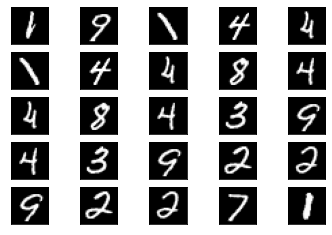

In [100]:
side = 5
start = np.random.random_integers(low=0, high=x_train.shape[0], size=(1,))[0]
fig, ax = plt.subplots(side, side)
for a in range(side):
    for b in range(side):
        ax[a, b].axes.xaxis.set_visible(False)
        ax[a, b].axes.yaxis.set_visible(False)
        ax[a, b].imshow(x_train[2 * a + b + start, :, :], cmap='gray')
plt.show()

In [101]:
x_train_norm = keras.utils.normalize(x_train)
x_test_norm = keras.utils.normalize(x_test)

x_train_flatten = x_train_norm.reshape(x_train_norm.shape[0], -1).T
print(x_train_flatten.shape)

## Code

## Import

In [ ]:
import numpy as np

## initialize_parameters

In [87]:
def initialize_parameters(layers_dims):
    parameters = {}
    L = len(layers_dims) - 1
        
    for l in range(1, L+1):
        parameters['W'+str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1]) * np.sqrt(2./layers_dims[l-1])
        parameters['b'+str(l)] = np.zeros((layers_dims[l], 1))
    
    return parameters

## activation_funtion

In [88]:
def activation_funtion(Z, activation):
    if activation == "relu":
        A = np.maximum(np.zeros(1), Z)
        print("activation:", activation)
        return A
        
    if activation == "sigmoid":
        A = 1 / (1-np.exp(-Z) + 1e-32)
        print("activation:", activation)
        return A
    
    print("activation: linear")
    return Z

## forward_propagation

In [89]:
def forward_propagation(X, parameters, activation):
    cache = {}
    L = len(parameters)// 2
    cache['A0'] = X
    
    for l in range(1,L):
        cache['Z'+str(l)] = np.dot(parameters['W'+str(l)], cache['A'+str(l-1)]) + parameters['b'+str(l)]
        cache['A'+str(l)] = activation_funtion(cache['Z'+str(l)], activation[l-1])
    l += 1
    
    cache['Z'+str(l)] = np.dot(parameters['W'+str(l)], cache['A'+str(l-1)]) + parameters['b'+str(l)]
    cache['A'+str(l)] = activation_funtion(cache['Z'+str(l)], activation[l-1])

    return cache

## compute_cost

In [95]:
def compute_cost(AL,Y, loss):
    m = Y.shape[1]
    
    AL = AL.T
    if loss == "cross_entropy":
        cost = -(1/m) * np.sum(np.multiply(np.log(AL), Y) + np.multiply(np.log(1-AL), 1-Y))
        return np.squeeze(cost)
        

## back_propagation

In [109]:
layers_dims = [x_train_flatten.shape[0],32,16,10]
activation = ["relu","relu","sigmoid"]
loss_funtion = "cross_entropy"

X = np.random.randn(layers_dims[0],1)
Y = np.array([[0, 1]])
print(Y.shape)
print(Y)

parameters = initialize_parameters(layers_dims)
cache = forward_propagation(x_train_flatten, parameters, activation)
print(compute_cost(cache['A'+str(len(layers_dims)-1)].T, y_train, loss_funtion))

(1, 2)
[[0 1]]
activation: relu
activation: relu
activation: sigmoid


NameError: name 'y_trainloss_funtion' is not defined

In [92]:
def back_propagation(X, parameters, cache):
    
    L = int(len(parameters)/2)
    l = 1